# Pair Selection

This is a proof of concept for selecting pairs of stocks that are cointegrated. Note that this requires an API key, so follow the instructions in the README to get one.

The process is as follows:

1. Get the prices for a list of stocks
2. Resample the prices to a common time frame (e.g. 1 hour)
3. For each pair of stocks, self-normalize the prices by their respective means. Calculate their spread and determine if it is stationary using the ADF test.

## tldr

This seems promising. Not sure how to handle normalizing the spread yet - it seems like a good idea, but I don't know how to calculate the mean for each price. Maybe it can be calculated at the start of each day?

In [123]:
from datetime import datetime, timedelta
from datetime import time
from itertools import combinations
import os
import sys

from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm

from src.utilities import getenv, load_dataframe, save_dataframe
from src.utilities.plotting import (
    plot_price_data,
    plot_split_dataframe,
    plt_show,
)
from src.utilities.market import nyse_holidays
from src.utilities.bars import download_close_prices, BarUtils
# add the src directory to the path
sys.path.append(os.path.join("..", "src"))

load_dotenv()

ALPACA_API_KEY = getenv("ALPACA_API_KEY")
ALPACA_API_SECRET = getenv("ALPACA_API_SECRET")
DATA_DIR = getenv("DATA_DIR")

In [124]:
utility_tickers = [
    "NEE", "EXC", "D", "PCG", "XEL", 
    "ED", "WEC", "DTE", "PPL", "AEE", 
    "CNP", "FE", "CMS", "EIX", "ETR", 
    "EVRG", "LNT", "PNW", "IDA", "AEP", 
    "DUK", "SRE", "ATO", "NRG",
]
refresh_bars = False # set to true to refresh the bars. this requires the alpaca api key and secret to be set in the .env file
start_date = datetime(2023, 1, 1)
end_date = datetime.today() - timedelta(minutes=15)
timeframe = TimeFrame.Hour

Refresh or load the actual bars:

Loading data/NEE_EXC_D_PCG_XEL_ED_WEC_DTE_PPL_AEE_CNP_FE_CMS_EIX_ETR_EVRG_LNT_PNW_IDA_AEP_DUK_SRE_ATO_NRG_2023-01-01_2025-07-19_1Hour_close_prices.pkl


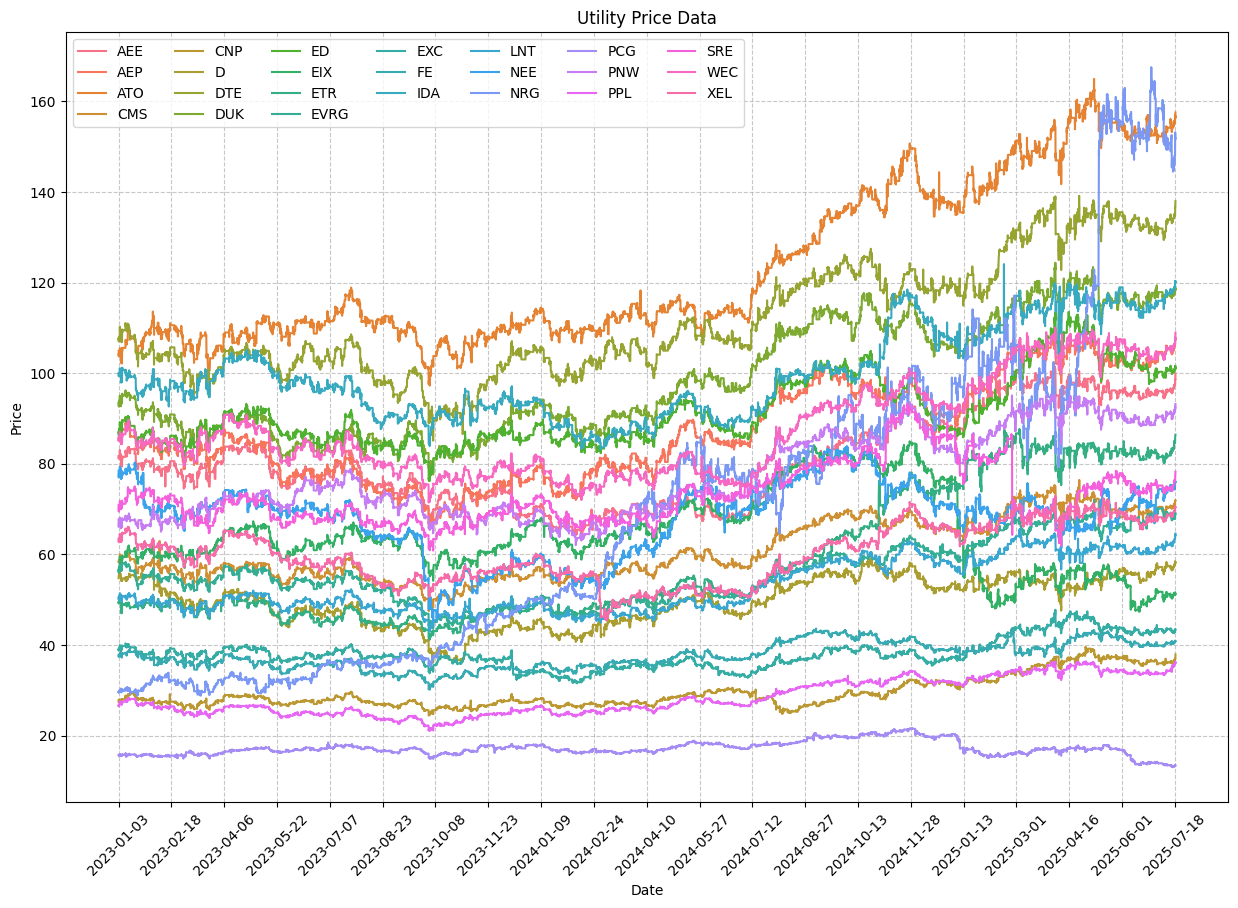

In [125]:
close_prices = download_close_prices(utility_tickers, start_date, end_date, timeframe, refresh_bars, DATA_DIR)

plot_price_data(close_prices, "Utility Price Data")
plt_show(prefix="utility_price_data")

Split the price into training and test periods:

In [126]:
tt_split = 0.8
# we want the strategy to train on
train_prices = close_prices.iloc[:int(tt_split * len(close_prices))]
test_prices = close_prices.iloc[int(tt_split * len(close_prices)):]
print(f"Train prices: {train_prices.shape}")
print(f"Test prices: {test_prices.shape}")

Train prices: (17804, 24)
Test prices: (4451, 24)


## Stationarity Testing

Now, we need to test the stationarity of the spread of each pair of stocks. We do this by calculating the spread and then using the ADF test to check if it is stationary. Note that we are dividing the prices by their mean to normalize them by dollar amount to mitigate asymmetry. We do this over the training period.

In [127]:
# calculate the cointegration results
cointegration_results = pd.DataFrame(index=utility_tickers, columns=utility_tickers)
cointegration_results = pd.DataFrame(columns=["p-value"])
for primary, secondary in combinations(utility_tickers, 2):
    pair = tuple(sorted([primary, secondary]))
    if pair in cointegration_results:
        continue
    #if cointegration_results.loc[secondary, primary] is not np.nan:
    #    continue

    # normalize the prices amd calculate the spread
    normalized_prices = train_prices[[primary, secondary]].apply(
        lambda x: (x / x.mean())
    )    
    spread = normalized_prices[primary] - normalized_prices[secondary]

    # calculate how stationary the spread is
    spread_pvalue = adfuller(spread, maxlag=0)[1]

    #cointegration_results.loc[primary, secondary] = spread_pvalue
    #cointegration_results.loc[secondary, primary] = spread_pvalue

    cointegration_results = pd.concat([cointegration_results, pd.DataFrame({"p-value": spread_pvalue}, index=[pair])])

/tmp/ipykernel_36504/2577038575.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cointegration_results = pd.concat([cointegration_results, pd.DataFrame({"p-value": spread_pvalue}, index=[pair])])


Show the results as a heatmap:

# show the cointegration results as a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(
    cointegration_results.values.astype(np.float32),
    annot=True,
    cmap="YlGnBu",
    fmt=".2f",
)
plt.grid(False)
plt.title("Cointegration Results")
plt.xlabel("Ticker")
plt.ylabel("Ticker")
plt.xticks(np.arange(len(utility_tickers)) + 0.5, utility_tickers, rotation=30)
plt.yticks(np.arange(len(utility_tickers)) + 0.5, utility_tickers, rotation=0)
plt.show()


In [128]:
cointegration_results = cointegration_results.sort_values(by="p-value")
cointegration_results

,p-value
"(CMS, DTE)",6.546993e-10
"(CMS, FE)",3.368455e-07
"(DTE, FE)",5.458689e-07
"(AEP, CMS)",5.924961e-05
"(AEE, WEC)",6.661620e-05
...,...
"(ETR, PCG)",9.831043e-01
"(ETR, FE)",9.831528e-01
"(ETR, EXC)",9.836426e-01
"(ED, ETR)",9.958447e-01


Let's see how well our selection extended into the test period.

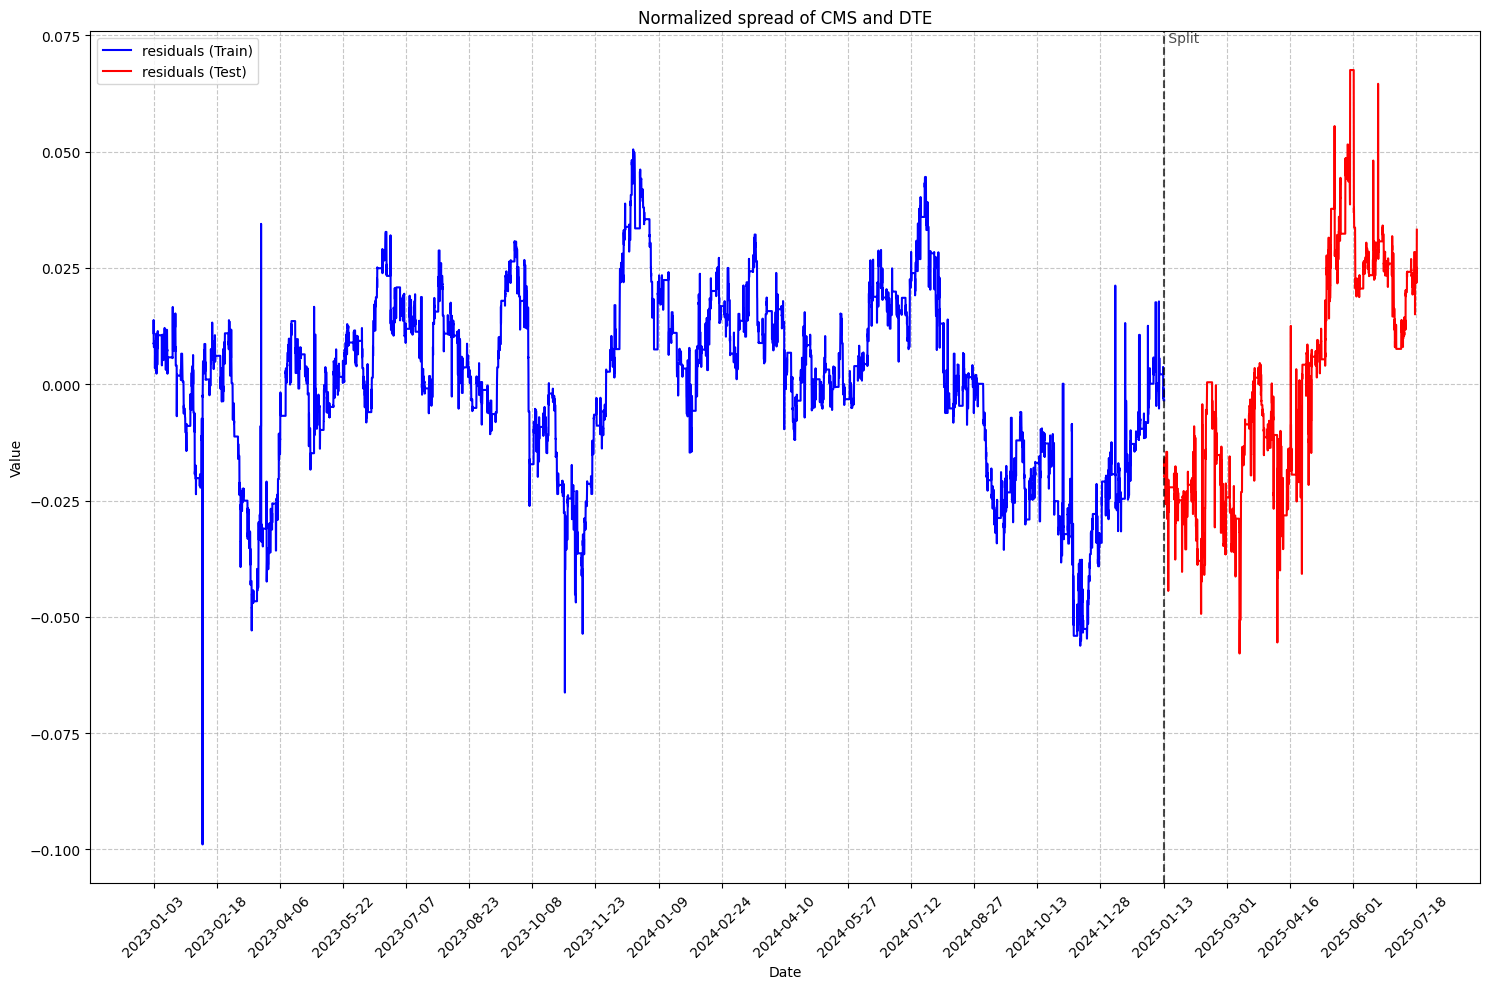

In [129]:
primary, secondary = cointegration_results.iloc[0].name
residuals_train = train_prices[secondary] / train_prices[secondary].mean() - train_prices[primary] / train_prices[primary].mean()
residuals_test = test_prices[secondary] / test_prices[secondary].mean() - test_prices[primary] / test_prices[primary].mean()

# plot the spread at both the train and test
combo = pd.DataFrame(pd.concat([residuals_train, residuals_test]), columns=["residuals"])
plot_split_dataframe(combo, len(train_prices), title=f"Normalized spread of {primary} and {secondary}")
plt_show(prefix="spread")

## Plot the spread and prices of the lowest pair

The signal plot shows the trading signals generated from the bollinger bands. When the spread is above the upper band, the signal is 1 (buy), and when the spread is below the lower band, the signal is -1 (sell). When the spread is between the bands, the signal is 0 (hold). Since this is pairs trading, a buy signal is a simultaneous buy of the primary and sell of the secondary, and vice versa for a sell signal. We are only plotting the test period.

In [130]:
primary, secondary = cointegration_results.iloc[0].name
prices = test_prices[[primary, secondary]].tail(720*3)


In [131]:
normalized_prices = prices.apply(lambda x: (x / x.mean()))
normalized_spread = normalized_prices[primary] - normalized_prices[secondary]

# make the normalized spread calculated by the rolling mean of each price
#normalized_spread = normalized_prices[primary].rolling(window=10).mean() - normalized_prices[secondary].rolling(window=10).mean()

# make bands
rolling_window = 8  # This is used for determining how many days ahead to use to calculate the rolling mean
std_multiplier = 2
rolling_mean = (
    normalized_spread.rolling(window=rolling_window).mean()
).dropna()
rolling_std = (normalized_spread.rolling(window=rolling_window).std()).dropna()
upper_band = rolling_mean + (rolling_std * std_multiplier)
lower_band = rolling_mean - (rolling_std * std_multiplier)

# fix the bands and rollings to be the same length as the spread
rolling_mean = rolling_mean.reindex(normalized_spread.index)    
upper_band = upper_band.reindex(normalized_spread.index)
lower_band = lower_band.reindex(normalized_spread.index)

# make a series where the value is 1 if the spread is above the upper band and -1 if it is below the lower band
position = pd.Series(
    np.where(
        normalized_spread > upper_band,
        1,
        np.where(normalized_spread < lower_band, -1, 0),
    ),
    index=normalized_spread.index,
)

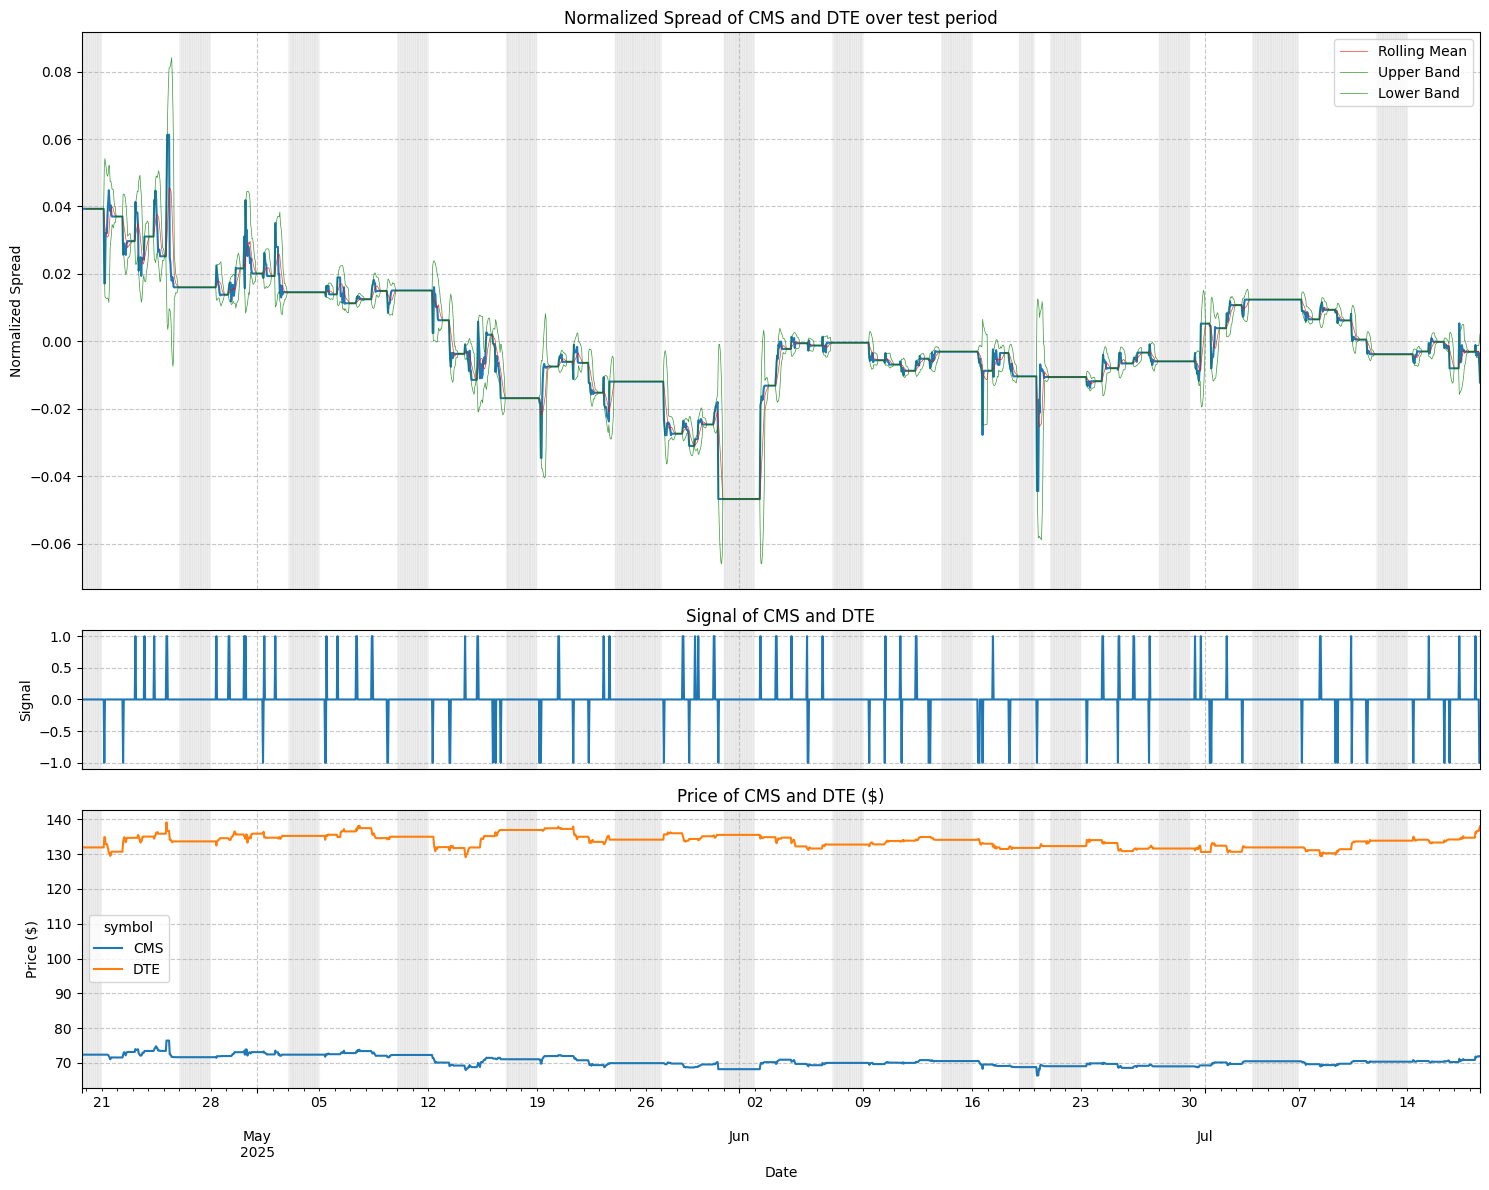

In [132]:
# Create figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1, figsize=(15, 12), height_ratios=[2, 0.5, 1]
)

# Plot spread in the largest subplot
normalized_spread.plot(
    ax=ax1, title=f"Normalized Spread of {primary} and {secondary} over test period"
)
rolling_mean.plot(
    ax=ax1, label="Rolling Mean", color="red", linewidth=0.5, alpha=0.8
)
upper_band.plot(
    ax=ax1, label="Upper Band", color="green", linewidth=0.5, alpha=0.8
)
lower_band.plot(
    ax=ax1, label="Lower Band", color="green", linewidth=0.5, alpha=0.8
)
ax1.set_ylabel("Normalized Spread")
ax1.set_xlabel("")
ax1.grid(True, linestyle="--", alpha=0.7)
ax1.legend()
ax1.tick_params(axis="x", which="both", bottom=False, labelbottom=False)

# Plot spread direction in the middle subplot
# don't slant the lines, make them straight
position.plot(ax=ax2, title=f"Signal of {primary} and {secondary}")
ax2.set_ylabel("Signal")
ax2.set_xlabel("")
ax2.grid(True, linestyle="--", alpha=0.7)
ax2.tick_params(axis="x", which="both", bottom=False, labelbottom=False)

# Plot individual prices in the bottom subplot
prices.plot(ax=ax3, title=f"Price of {primary} and {secondary} ($)")
ax3.set_ylabel("Price ($)")
ax3.set_xlabel("Date")
ax3.grid(True, linestyle="--", alpha=0.7)

# if the index is a weekend, put a rectangle on the plot
for index in prices.index:
    if index.weekday() >= 5 or index.date() in nyse_holidays:
        for ax in [ax3, ax2, ax1]:
            ax.axvspan(index, index, color="gray", alpha=0.08)

plt.tight_layout()
plt.show()